In [29]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, betas_ns_ols
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from scipy.optimize import minimize
from statsmodels.graphics.api import qqplot
%matplotlib inline

In [30]:
def missing_values_table(df):
    """
    Input: A data frame
    Ouput: Amount of missing values,
         Percentage of missing values in each feature
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [148]:
def plot_3d_nelson_siegel(data, maturity, start_date=2016, end_date=2019):
    
    x = np.array(np.linspace(start_date, end_date, len(data)))
    y = maturity
    x, y = np.meshgrid(x, y)
    z = data.values.T
    assert x.shape == y.shape, f'{x.shape} != {y.shape}'
    assert x.shape == z.shape, f'{x.shape} != {z.shape}'

    # Set up plot
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_zlabel('Rate', fontsize=10)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Maturity (Yearly)', fontsize=10)
    ax.set_title('Yield Surface of Historical data')
    ls = LightSource(270, 45)
    # To use a custom hillshading mode, override the built-in shading and pass
    # in the rgb colors of the shaded surface calculated from "shade".
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                           linewidth=0, antialiased=False, shade=False)
    plt.show()
    return None

# Formatting and Cleaning data

In [63]:
data = pd.read_csv('OIS-daily-data_2016-to-present.csv').dropna()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', drop=True, inplace=True)

# Select maturity and columns
month_maturity = np.arange(1,61)
column = month_maturity.astype(str)
year_maturity = month_maturity / 12
data = data / 100
print("Number of (row, column): ", data.shape)

# # Select maturity and columns
# month_maturity = np.arange(1,61)
# column = month_maturity.astype(str)
# year_maturity = month_maturity / 12
# data = data / 100
# print("Number of (row, column): ", data.shape)

Number of (row, column):  (991, 60)


# Demo a Yield Curve

NelsonSiegelCurve(beta0=0.005753998207038583, beta1=0.001768636846447633, beta2=-0.0036989813780046927, tau=0.71731275)


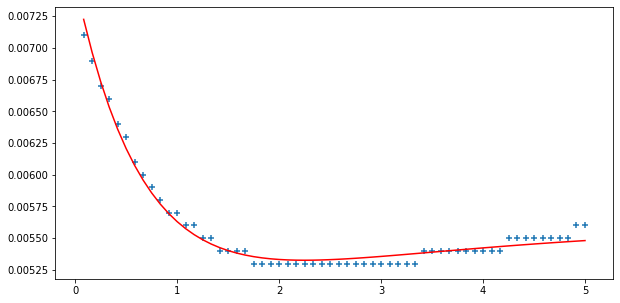

In [73]:
t = year_maturity
y = data.loc['2019-11-22'].values
tau = 0.71731275

curve, _ = betas_ns_ols(tau, t, y)
print(curve)
plt.figure(figsize=(10,5))
plt.plot(t, curve(t), c='red')
plt.scatter(t, y, marker='+')
plt.show()

# Find Tau

In [74]:
def neg_medium_term(lbda):
    a = 30 * lbda / 12
    return -(((1 - np.exp(-a)) / a) - np.exp(-a))

In [75]:
minimize(neg_medium_term, x0=0.0609)

      fun: -0.29842560752563674
 hess_inv: array([[2.16751045]])
      jac: array([-3.7252903e-08])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([0.71731275])

In [50]:
tau = 0.71731275

We choose $\lambda_t = 0.05977608$ as the result the solver gave us. In Diebold (2006), $\lambda_t = 0.0609$. However, it doesn't change the result much.

# Find betas

In [76]:
def compute_nelson_param(df):
    y = df.values
    t = year_maturity
    while True:
        try: 
            curve, _ = betas_ns_ols(tau, t, y)
            return [curve.beta0, curve.beta1, curve.beta2]
        except:
            print(f"Error at {df.index}")
            return [np.nan]*3

In [77]:
data[['beta0', 'beta1', 'beta2']] = data.apply(lambda x: pd.Series(compute_nelson_param(x), index=['beta0', 'beta1', 'beta2']), axis=1)

In [79]:
data.to_csv('data_NS_params_tau_0.71731275.csv')
data.shape

(991, 63)

# Plot 3d Nelson Siegel

In [80]:
data = pd.read_csv('data_NS_params_tau_0.71731275.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.interpolate(inplace=True, )
data.shape

(991, 63)

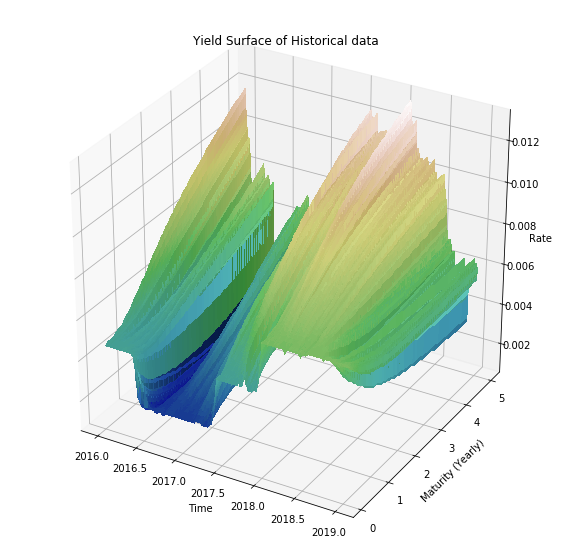

In [149]:
plot_3d_nelson_siegel(data[column], year_maturity)

# Simulate 2 years term structure

In [86]:
# Select data
beta0 = data.beta0.values
beta1 = data.beta1.values
beta2 = data.beta2.values

# Select model for each data
ar_beta0_ = AR(beta0).fit(maxlag=1)
ar_beta1_ = AR(beta1).fit(maxlag=1)
ar_beta2_ = AR(beta2).fit(maxlag=1)

# Estimated coefficient
print(ar_beta0_.params)
print(ar_beta1_.params)
print(ar_beta2_.params)

[8.51814070e-05 9.88992716e-01]
[-2.57716048e-05  9.89480283e-01]
[-1.39753626e-04  9.74371109e-01]


In [113]:
np.sqrt(np.var(ar_beta0_.resid))

0.00046056138384389597

In [121]:
# Simulate beta0
beta0_simulate = {}
beta1_simulate = {}
beta2_simulate = {}
sd0 = np.sqrt(np.var(ar_beta0_.resid))
sd1 = np.sqrt(np.var(ar_beta1_.resid))
sd2 = np.sqrt(np.var(ar_beta2_.resid))

h = 1000
n = len(beta0)
# sd = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]

# for _ in sd:
#     # Simulate beta0
#     beta0_simulate['beta0_' + str(_)] = ar_beta0_.predict(
#         start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=_, size=h)

#     # Simulate beta1
#     beta1_simulate['beta1_' + str(_)] = ar_beta1_.predict(
#         start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=_, size=h)

#     # Simulate beta2
#     beta2_simulate['beta2_' + str(_)] = ar_beta2_.predict(
#         start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=_, size=h)

# Simulate beta0
beta0_simulate['beta0'] = ar_beta0_.predict(
    start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=sd0, size=h)

# Simulate beta1
beta1_simulate['beta1'] = ar_beta1_.predict(
    start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=sd1, size=h)

# Simulate beta2
beta2_simulate['beta2'] = ar_beta2_.predict(
    start=n, end=n + h - 1) + stats.norm.rvs(loc=0, scale=sd2, size=h)

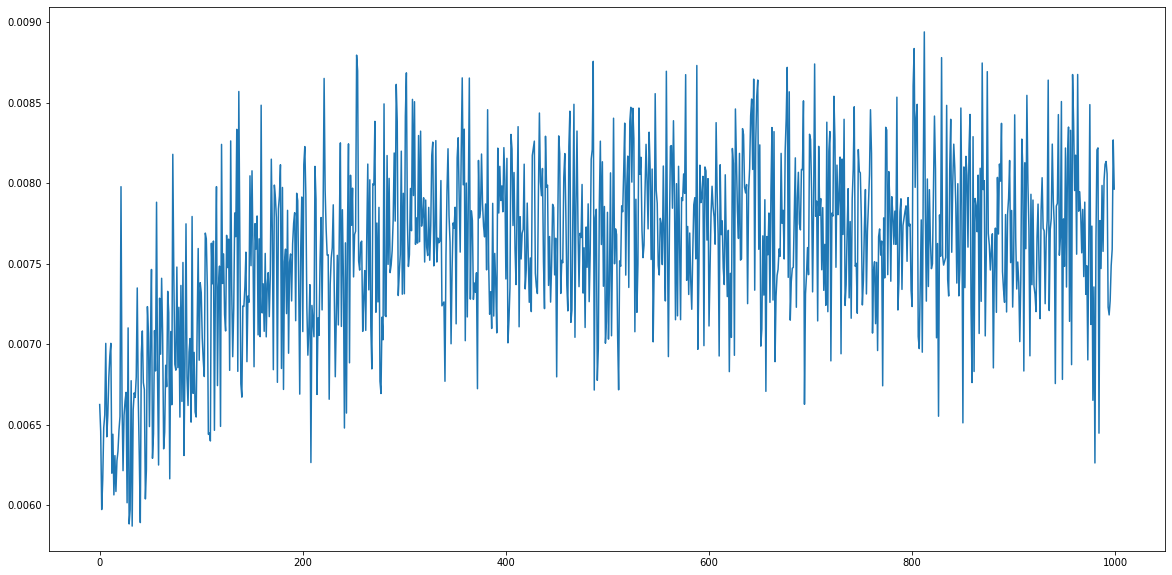

In [122]:
plt.figure(figsize=(20,10))
# plt.plot(beta0) np.arange(len(beta0), len(beta0)+h),
for series in beta0_simulate:
    plt.plot( beta0_simulate[series])

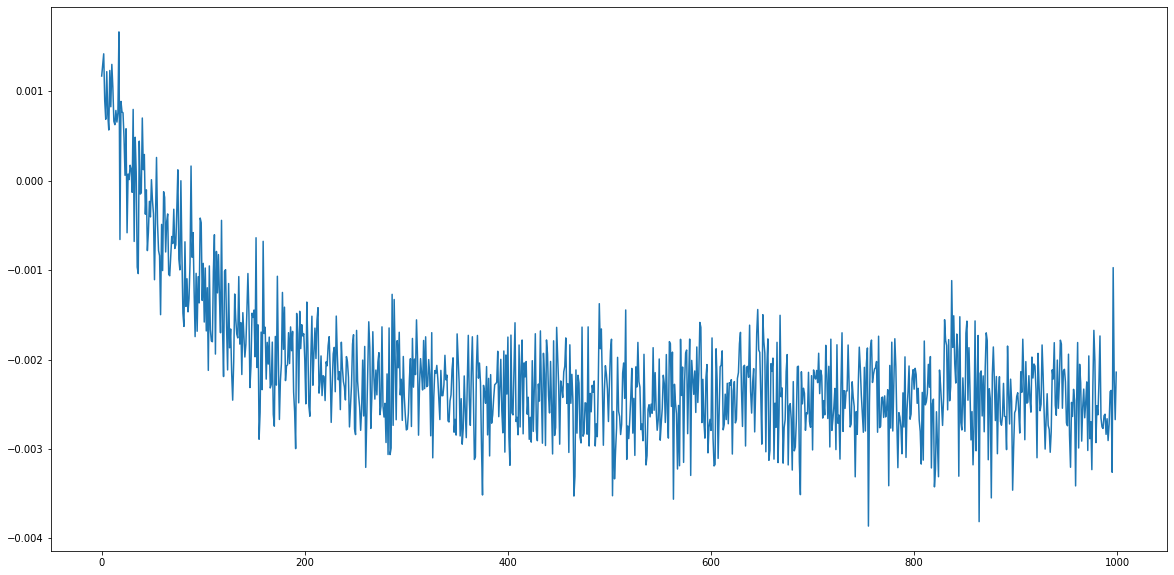

In [123]:
plt.figure(figsize=(20,10))
# plt.plot(beta0) np.arange(len(beta0), len(beta0)+h),
for series in beta1_simulate:
    plt.plot( beta1_simulate[series])

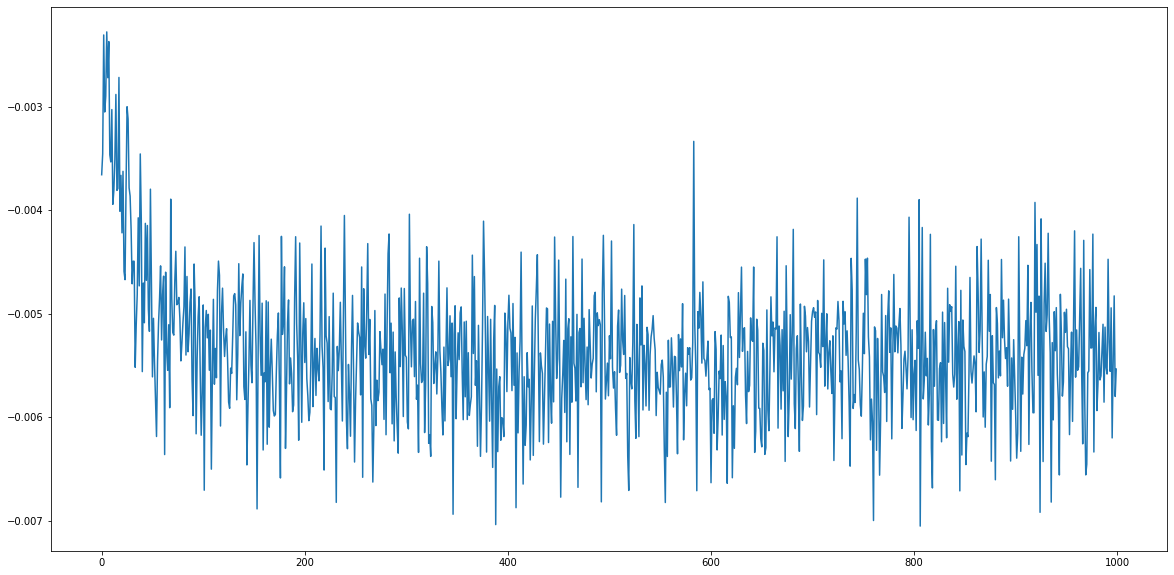

In [124]:
plt.figure(figsize=(20,10))
# plt.plot(beta0) np.arange(len(beta0), len(beta0)+h),
for series in beta2_simulate:
    plt.plot( beta2_simulate[series])

In [125]:
df_beta0_simulate = pd.DataFrame(beta0_simulate)
df_beta1_simulate = pd.DataFrame(beta1_simulate)
df_beta2_simulate = pd.DataFrame(beta2_simulate)

In [126]:
df_param_simulate = pd.concat(
    [df_beta0_simulate, df_beta1_simulate, df_beta2_simulate], axis=1)
df_yield_simulate = pd.DataFrame()

# for m in year_maturity:
#     m = round(m,4)
#     for s in sd:
#         df_yield_simulate[str(m)+'_sd_'+str(s)] = NelsonSiegelCurve(df_param_simulate['beta0_'+str(s)],
#                                                df_param_simulate['beta1_'+str(s)],
#                                                df_param_simulate['beta2_'+str(s)], tau)(m)

for m in year_maturity:
    m = round(m,4)
    df_yield_simulate[str(m)] = NelsonSiegelCurve(df_param_simulate['beta0'],
                                           df_param_simulate['beta1'],
                                           df_param_simulate['beta2'], tau)(m)

In [128]:
df_yield_simulate.head()

,0.0833,0.1667,0.25,0.3333,0.4167,0.5,0.5833,0.6667,0.75,0.8333,...,4.25,4.3333,4.4167,4.5,4.5833,4.6667,4.75,4.8333,4.9167,5.0
0,0.007534,0.007306,0.007107,0.006935,0.006785,0.006656,0.006545,0.006450,0.006369,0.006299,...,0.006216,0.006223,0.006230,0.006237,0.006243,0.006249,0.006255,0.006261,0.006267,0.006272
1,0.007492,0.007266,0.007070,0.006899,0.006750,0.006621,0.006510,0.006413,0.006331,0.006260,...,0.006103,0.006109,0.006115,0.006121,0.006126,0.006131,0.006137,0.006142,0.006147,0.006151
2,0.007190,0.007010,0.006852,0.006713,0.006591,0.006483,0.006389,0.006306,0.006234,0.006170,...,0.005830,0.005832,0.005834,0.005836,0.005839,0.005841,0.005843,0.005845,0.005846,0.005848
3,0.006840,0.006653,0.006492,0.006351,0.006230,0.006126,0.006036,0.005959,0.005893,0.005838,...,0.005803,0.005809,0.005815,0.005820,0.005826,0.005831,0.005837,0.005842,0.005847,0.005852
4,0.006975,0.006806,0.006660,0.006534,0.006426,0.006333,0.006253,0.006186,0.006129,0.006081,...,0.006117,0.006123,0.006129,0.006135,0.006141,0.006146,0.006152,0.006157,0.006162,0.006167


In [129]:
df_yield_simulate.to_csv('OIS_simulate_1000_lines.csv')

In [ ]:
plot_3d_nelson_siegel()